# Kobe Bryant Shot Selection


#### The idea is taken from the Kaggle competition : 
#### https://www.kaggle.com/c/kobe-bryant-shot-selection

#### I will use this data to train a predictor on Kobe Bryant shoots

## Import libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.misc import imread #enables the notebook to read images

In [2]:
%matplotlib inline 

sns.set_style("white") #set white background for seaborn plots

In [4]:
url = "/home/jo/anaconda2/Kobe/data.csv"
df_data_with_nan = pd.read_csv(url)
df_data = df_data_with_nan.dropna(subset=['shot_made_flag']).reset_index(drop=True) #remove line where shot_made_flag is NaN

## Exploring the data

In [6]:
df_data.columns.values

array(['action_type', 'combined_shot_type', 'game_event_id', 'game_id',
       'lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period',
       'playoffs', 'season', 'seconds_remaining', 'shot_distance',
       'shot_made_flag', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'team_id', 'team_name', 'game_date', 'matchup',
       'opponent', 'shot_id'], dtype=object)

In [7]:
df_data.head(10)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
1,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
2,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
3,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
4,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
5,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7
6,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,...,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9
7,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10
8,Jump Shot,Jump Shot,309,20000012,33.8063,-94,238,-118.3638,1,3,...,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,11
9,Jump Shot,Jump Shot,4,20000019,33.9173,121,127,-118.1488,11,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-11-01,LAL vs. UTA,UTA,12


Quick check on most frequent shoots

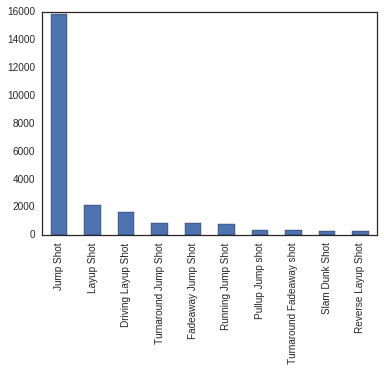

In [8]:
df_data['action_type'].value_counts()[:10].plot(kind='bar');

Quick check on frequent opponents.

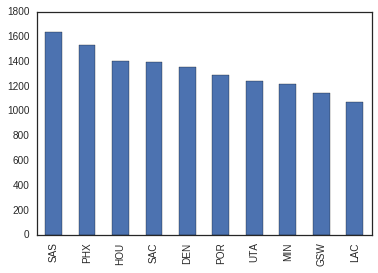

In [10]:
df_data['opponent'].value_counts()[:10].plot(kind='bar');

Ploting the ration of made/failed shots on some particular games

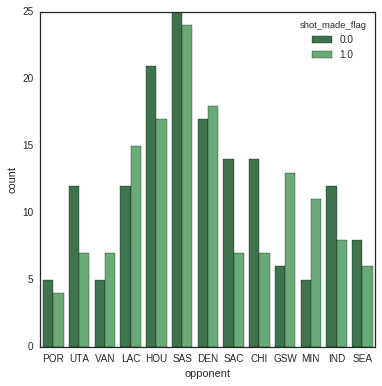

In [11]:
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set figure sizes
sns.countplot(x='opponent', hue='shot_made_flag', data=df_data[:300], palette='Greens_d');

A NBA Basketball half-court is 47' vs 50'. The 0 position is located 4' after the baseline
(source : https://upload.wikimedia.org/wikipedia/commons/6/6c/Basketball_courts.svg ).
So now we can plot the shots positions and add the court as a background image.

To save readability of the picture let's plot only shots against Los Angeles Clippers.

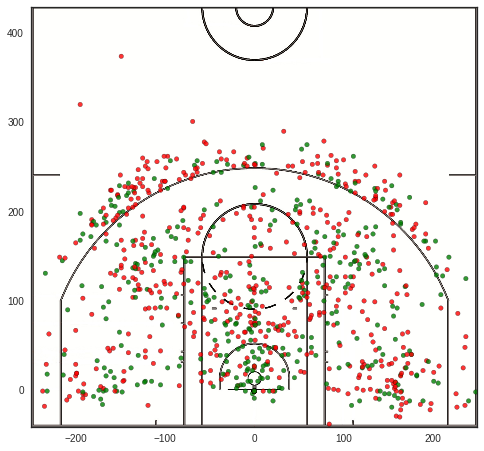

In [12]:
team_cond = df_data['opponent']=='LAC'

colors = {1.0:'green',0.0:'red'}
img = imread("nba_field.jpg")

plt.rcParams['figure.figsize'] = (8.0, 10.0) # set figure sizes

plt.scatter(df_data[team_cond]["loc_x"],df_data[team_cond]["loc_y"],c=df_data[team_cond]["shot_made_flag"].apply(lambda x: colors[x]),zorder=1, alpha=0.8)
plt.imshow(img, zorder=0, extent=[-250, 250, -40, 430]) #Use the extent keyword of imshow. The order of the argument is [left, right, bottom, top]

plt.show()

### Now that we better understand the data we have, we can start building a  predictive model to guess whether or not Bryant scored his shot.

#### To do so, we will train consecutive logistic regressions, increasing at each step the features selection. Logistic regression is probably not the best model for our problem, but I hope we will have some interesting results at the end.

The first step is to split the data we have to determine a training set, a cross validation set and a test set. 

Depending on the end-application of our algorithm we should define a test set specificaly. For example, if we want to predict all the shots of the next game, we should take a test set of events that always occur after the training set.

In this case, we will take a simplified approach, we will just try to guess if one random shoot was sinked, considering any other shoot. So we can split all sets randomly.

### For the first scenario, we will only use the X,Y position of the shoot as input features for our Logistic Regression. Don't expect too much about it.

In [13]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import cross_validation

In [14]:
data = df_data[["loc_x","loc_y","shot_made_flag"]]

le = preprocessing.LabelEncoder()
X = data.drop("shot_made_flag", axis=1) #we still need to simplify the data, put it in the [-1,1] interval
Y = le.fit_transform(data["shot_made_flag"].values)

#conv_X = pd.get_dummies(data[["loc_x","loc_y"]]) #i.e. one hot encoding (ohe)

In [47]:
indices = np.arange(len(X))
np.random.shuffle(indices)

train_indices=indices[:len(x)*4/5]
test_indices= indices[len(X)*4/5:]

In [48]:
total_auc = 0 #total will be used to measure the AUC of the ROC function


train_X = X.ix[train_indices, :]
train_Y = Y[train_indices]
test_X = X.ix[test_indices, :]
test_Y = Y[test_indices]

# Train the model, and evaluate it
reg = linear_model.LogisticRegression()
reg.fit(train_X, train_Y)

predictions = reg.predict_proba(test_X)[:, 1]

fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
total_auc += metrics.auc(fpr, tpr)
        
accuracy = total_auc 
print "AUC of Logistic Regression: {0}".format(accuracy)

AUC of Logistic Regression: 0.591196314914


Let's try to visualize what would be the probability to score from anywhere on the court. According to the last run of the Logistic Regression.

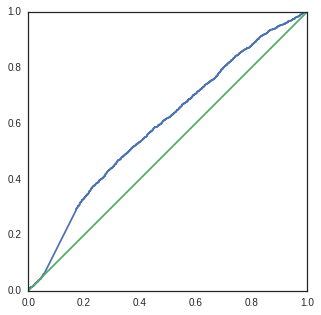

In [50]:
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.plot(fpr, tpr)
plt.plot(np.linspace(0.0, 1.0, 100),np.linspace(0.0, 1.0, 100));

In [51]:
x_min= -250
x_max= 250
y_min= -40
y_max= 430

nb_X_points=(x_max-x_min)/10 #50 points
nb_Y_points=(y_max-y_min)/10 #47 points

loc_x = np.linspace(x_min,x_max,nb_X_points) 
loc_y = np.linspace(y_min,y_max,nb_Y_points) 

all_X = np.tile(loc_x, nb_Y_points)
all_Y = np.repeat(loc_y, nb_X_points)
all_court = np.transpose([all_X, all_Y])

predictions_on_court = reg.predict_proba(all_court)[:, 1].reshape((nb_X_points, nb_Y_points))

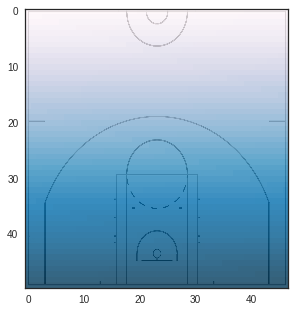

In [52]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.imshow(img, zorder=0, extent=[0, 46, 49, 0])
plt.imshow(predictions_on_court, interpolation='nearest', cmap='PuBu_r', alpha=0.8);

According to our model, the 'bluer' you are on this graph, the higher is your chance to score.

It seems that the X position is not relevant according to our primary model, which is obviously wrong. (It's much more difficult to score from the bottom left corner, than from under the ring.)

Let's try to do a little bit better now with some feature engineering.

In [53]:
def polar_r(data):
    return np.sqrt(data["loc_x"]**2+data["loc_y"]**2)
     
def polar_theta(data):
    #we choose to have theta=0 angle is when X=0
    return np.arctan2(-data["loc_x"],data["loc_y"])

data["r"]=data.apply(polar_r,axis=1)
data["theta"] = data.apply(polar_theta,axis=1)

data.head()

/home/jo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,loc_x,loc_y,shot_made_flag,r,theta
0,-157,0,0.0,157.000000,1.570796
1,-101,135,1.0,168.600119,0.642315
2,138,175,0.0,222.865430,-0.667733
3,0,0,1.0,0.000000,-0.000000
4,-145,-11,0.0,145.416643,1.646513


Did you guess? 

Yes, we'll introduce polar coordinates to see if we can already do better.

In [54]:
data_polar = data[["r","theta","shot_made_flag"]]

le = preprocessing.LabelEncoder()
X = data_polar.drop("shot_made_flag", axis=1) #we still need to simplify the data, put it in the [-1,1] interval
Y = le.fit_transform(data_polar["shot_made_flag"].values)


In [55]:
numFolds=10
kf = cross_validation.KFold(len(X), numFolds, shuffle=True) #We will use 10 KFolds division

In [56]:
total_auc = 0 #total will be used to measure the AUC of the ROC function

for train_indices, test_indices in kf:
        # Get the dataset; this is the way to access values in a pandas DataFrame
        train_X = X.ix[train_indices, :]
        train_Y = Y[train_indices]
        test_X = X.ix[test_indices, :]
        test_Y = Y[test_indices]

        # Train the model, and evaluate it
        reg = linear_model.LogisticRegression()
        reg.fit(train_X, train_Y)
        
        predictions = reg.predict_proba(test_X)[:, 1]
        
        fpr, tpr, _ = metrics.roc_curve(test_Y, predictions)
        total_auc += metrics.auc(fpr, tpr)
        
accuracy = total_auc / numFolds
print "AUC of Logistic Regression: {0}".format(accuracy)

AUC of Logistic Regression: 0.610571879184


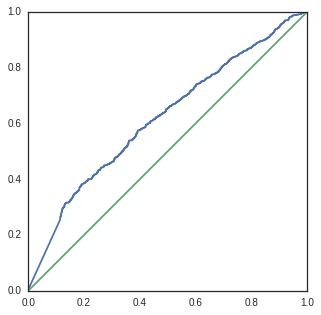

In [57]:
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.plot(fpr, tpr)
plt.plot(np.linspace(0.0, 1.0, 100),np.linspace(0.0, 1.0, 100));

In [59]:
def polar(position):
    return np.sqrt(position[0]**2+position[1]**2), np.arctan2(-position[0],position[1])


In [60]:
x_min= -250
x_max= 250
y_min= -40
y_max= 430

nb_X_points=(x_max-x_min)/10 #50 points
nb_Y_points=(y_max-y_min)/10 #47 points

loc_x = np.linspace(x_min,x_max,nb_X_points) 
loc_y = np.linspace(y_min,y_max,nb_Y_points) 

all_X = np.tile(loc_x, nb_Y_points)
all_Y = np.repeat(loc_y, nb_X_points)
all_court = np.transpose([all_X, all_Y])

all_court_polar = np.apply_along_axis(polar,1,all_court)

predictions_on_court = reg.predict_proba(all_court_polar)[:, 1].reshape((nb_X_points, nb_Y_points))

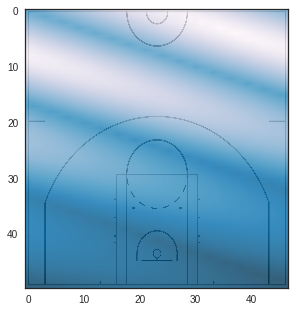

In [61]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set figure sizes

plt.imshow(img, zorder=0, extent=[0, 46, 49, 0])
plt.imshow(predictions_on_court, interpolation=None, cmap='PuBu_r', alpha=0.8);

In [169]:
print all_court_polar

(array([ 346.41316728,   56.56854249]), array([ 2.33536417,  2.35619449]))


In [170]:
print all_court

[[-250.          -40.        ]
 [-239.79591837  -40.        ]
 [-229.59183673  -40.        ]
 ..., 
 [ 229.59183673  430.        ]
 [ 239.79591837  430.        ]
 [ 250.          430.        ]]


In [178]:
np.apply_along_axis(polar,1,all_court)

array([[  2.53179778e+02,   1.72945159e+00],
       [  2.43109199e+02,   1.73608301e+00],
       [  2.33050234e+02,   1.74328723e+00],
       ..., 
       [  4.87455035e+02,  -4.90425249e-01],
       [  4.92343460e+02,  -5.08708939e-01],
       [  4.97393205e+02,  -5.26627271e-01]])